In [1]:
import os
import re
import speech_recognition as sr
from pydub import AudioSegment
from pytube import YouTube
import librosa
import soundfile
from youtube_transcript_api import YouTubeTranscriptApi
from scipy.io.wavfile import read, write

import numpy as np
import time
import math
#from googleapiclient.discovery import build
import whisper_timestamped as whisper
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

C:\ProgramData\anaconda3\envs\find_keyword_inyt\Lib\site-packages\whisper\timing.py:57: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



C:\ProgramData\anaconda3\envs\find_keyword_inyt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0. YT age verification
- Please follow the link and enter code.

In [2]:
yt = YouTube('https://www.youtube.com/watch?v=vv0r9yiQG-w', use_oauth=True, allow_oauth_cache=True)
#yt = YouTube('https://www.youtube.com/watch?v=vv0r9yiQG-w')
print(yt.title, yt.length, yt.author)

What alpha brainwaves can teach us about loneliness | Lisa Miller 378 Big Think


## 1. Download the Youtube's audios from a `yt_dl_list.txt`
- Update the `search_pattern` to the keyword you want. 


In [3]:
# Set the search pattern for the desired paragraph
search_pattern = r"reset"

# Set the path to the ffmpeg binary (required by SpeechRecognition)
#ffmpeg_path = "C:\\Users\\{User_name}\\....\\ffmpeg-2023-06-27-git-9b6d191a66-essentials_build\\bin"

- 1. Get the keyword video link from this website: https://youglish.com/pronounce/reset/english?
- 2. Copy all the Youtube's link which exist the keyword to `yt_dl_list.txt`
- 3. Execute the below block, and update the finish YT links in `yt_dl_list_finish.txt` which will be used latter.
- 4. Sometimes it maybe fail downloading with many links, please remove the finish links in `yt_dl_list.txt` and start this blocks again.

In [22]:
def onProgress(stream, chunk, remains):
    total = stream.filesize                     # 取得完整尺寸
    percent = (total-remains) / total * 100     # 減去剩餘尺寸 ( 剩餘尺寸會抓取存取的檔案大小 )
    print(f'downloading… {percent:05.2f}', end='\r')  # 顯示進度，\r 表示不換行，在同一行更新

# Download audio from YouTube video and convert to WAV format
def download_youtube_audio_pytube(video_url):
    # Extract video ID from the video URL
    if "youtu.be" in video_url:
        video_id = video_url.split("youtu.be/")[1]
    elif "watch?v=" in video_url:    
        video_id = video_url.split("watch?v=")[1]
    else:
        print("The link is error: {}".format(video_url)) 

    mp3_audio_name = os.path.join('downloadYT_raw', search_pattern, (video_id + r'.mp3'))
    wav_audio_name = os.path.join('downloadYT_raw', search_pattern, (video_id + r'.wav'))
    #print(mp3_audio_name)
    
    yt = YouTube(video_url, on_progress_callback=onProgress, use_oauth=True, allow_oauth_cache=True)
    print(yt.title, yt.length, yt.author) # 影片標題, 影片長度 ( 秒 ), 影片作者 
    
    yt.streams.filter().get_audio_only().download(filename=mp3_audio_name)
    
    # Transfer to wav format, because the next process need wav pcm format.
    sound = AudioSegment.from_file(mp3_audio_name)
    sound.export(wav_audio_name, format="wav")
    
    print('Finish!')
    os.remove(mp3_audio_name)
    
    return wav_audio_name

# Create the folder to save the TY audio
if not os.path.exists(os.path.join('downloadYT_raw', search_pattern)):
    os.makedirs(os.path.join('downloadYT_raw', search_pattern))

# Start to loop the line in yt list file
dl_count = 0
with open('yt_dl_list.txt') as f:
    for line in f:
       dl_count += 1 
       download_youtube_audio_pytube(line.strip())
       print("Download {} audio!".format(dl_count)) 
print("Finish all download {}.".format(dl_count))


Rha Goddess on Taking a Sacred Pause in 2020 & Getting into Alignment w/ Your Inner Truth 3615 Marie Forleo
Finish!ding… 100.00
Download 1 audio!
Veterans and PTSD 1652 Attitude
Finish!ding… 100.00
Download 2 audio!
DIY Block Print Gift Wrap 2744 Blick Art Materials
Finish!ding… 100.00
Download 3 audio!
03/09/21: Press Briefing by Press Secretary Jen Psaki and Bharat Ramamurti 3284 The White House
Finish!ding… 100.00
Download 4 audio!
02/25/21: Press Briefing by Press Secretary Jen Psaki 2370 The White House
Finish!ding… 100.00
Download 5 audio!
Inviting Brighter Days ☀️ 2021 Artist of Life Workbook 293 Lavendaire
Finish!ding… 100.00
Download 6 audio!
Economics 1616 Iowa Press
Finish!ding… 100.00
Download 7 audio!
Election 2020: What has President Trump done to America? 818 The Economist
Finish!ding… 100.00
Download 8 audio!
Chocolate (ft. Sohla El-Waylly) | Basics with Babish 856 Babish Culinary Universe
Finish!ding… 100.00
Download 9 audio!
Post-Launch Book Marketing Tips with SA Bra

## 2. Find & Crop the keyword wav file.
- This section will read the lines in `yt_dl_list_finish.txt` and find the downloaded audio with its transcript.

In [64]:
# Create a SpeechRecognition Recognizer instance
# recognizer = sr.Recognizer()
dict_log = {} # The log for transcribe_cut_audio & cut_audio_segment

def wave_converter(filename, origin_sr, origin_data, resampled_sr=16000, prefix="resampled_", mix2mono = True):

    '''
    Resample WAV soundfile to a different sample rate.
    
        Input: original sound file
        Output: resampled sound file
        Parameters: 
            - name of the file to be converted, 
            - destination sample rate, default = 16kHz
            - prefix to identify resampled files
            - mix to mono channel, default = False (leave as-is)
            
        Notes: for simplicity it needs to be run in the folder with the files we are converting
    '''    
    
    resampled_file = prefix + filename + '.wav'
    origin_type = origin_data.dtype

    #print(resampled_file, origin_type)
    
    # transpose array to librosa shape
    resampled_data = librosa.resample(origin_data.T.astype('float'), orig_sr = origin_sr,  target_sr = resampled_sr) 
    
    if mix2mono == True:
        resampled_data = librosa.to_mono(resampled_data)
    if origin_type != 'int16':
        print("Warning: the data type is changed from {} to int16".format(origin_type))
        resampled_data = resampled_data.T.astype('int16') # transpose back to scipy.io.wavfile shape
    else:
        resampled_data = resampled_data.T.astype(origin_type) # transpose back to scipy.io.wavfile shape
    
    write(resampled_file, resampled_sr, resampled_data)
    #print('Resampled wavefile saved to {}'.format(resampled_file))


# Transcribe audio and grep desired paragraph
def transcribe_cut_audio(f_log, audio_file, search_pattern, video_id, dict_single_log, ma_cut):
    #----------------------
    # Basing on the YT transcript to cut the section of search_pattern to a small audio first.
    #----------------------
    t_s = 0
    t_e = 0
    buf_time = 5 # bcs the recognize_google need a long enough audio.
    
    rate, data = read(audio_file)       
    #print(rate, len(data))
    
    # assigning srt with the list of dictionaries obtained by the get_transcript() function
    #x = YouTubeTranscriptApi.list_transcripts(video_id) 
    #print(x) 
    
    try:
       srt = YouTubeTranscriptApi.get_transcript(video_id, languages=['en', 'en-US', 'en-GB'])
    except:
       #srt = YouTubeTranscriptApi.get_transcript(video_id, languages=['en-US'])
       print("Error: There is no srt from YouTubeTranscriptApi.get_transcript or the languages are not 'en' or 'en-US', ID: {}".format(video_id))
    
    for dict_text in srt:
        search_pattern = r'\b{}\b'.format(search_pattern)
        #match = re.findall(pattern, string)
        match = re.search(search_pattern, dict_text['text'], re.IGNORECASE)
        #print(match)
        if match:
            t_s = (int)(dict_text['start']) * rate
            t_e = (int)(dict_text['start'] + dict_text['duration']) * rate
            #print('\n')
            #print('Found search_pattern section: {}'.format((int)(dict_text['start'])))
            #print(dict_text['text'], t_s, t_e)
            #print('\n')
            
    if t_s==0 and t_e==0:
        print("Error: There is no any match keyword. ID: {}".format(video_id))
    
    if (t_s - rate * buf_time) >= 0:
        t_s = t_s - rate * buf_time
    t_e = t_e + rate * buf_time
    dict_single_log['cut_t_s_idx'] = t_s
    dict_single_log['cut_t_e_idx'] = t_e
    # write("{}.wav".format('tempcut'), rate, data[t_s:t_e])

    #----------------------
    # Convert to 16khz, mono, int16
    #----------------------
    #print(t_s, t_e)
    wave_converter('cut', rate, data[t_s: t_e])

    #----------------------
    # cut_audio_segment
    #----------------------
    keyword_dict = cut_audio_segment(f_log, video_id, dict_single_log, ma_cut)
 
    
    return keyword_dict

def cut_audio_segment(f_log, video_id, dict_single_log, ma_cut):    
   audio = whisper.load_audio('resampled_cut.wav')
   model = whisper.load_model("base")
   result = whisper.transcribe(model, audio, language="en")
   #print(json.dumps(result, indent = 2, ensure_ascii = False))
    
   # check first, if the search pattern is in result['text'] string or not.
   if not(search_pattern.lower() in result['text'].lower()):
        print("Error: There is no search_pattern in the resampled_cut.wav. ID: {}".format(video_id))
        print("You can search for second keyword(need update the code in transcribe_cut_audio()), or skip this wav directly.")
        print("The other way is clipping the keyword manually.(Search comments: Manually clip)")
        print("It is because whisper API can't recognize the keyword when there are different speakers or some other interference.")
  
   # check if search_pattern is 2 word keyword.
   if ' ' in search_pattern:
       search_pattern_0 = search_pattern.split(' ')[0]
       search_pattern_1 = search_pattern.split(' ')[1]
        
       # Find the match keyword and its start&end time
       t_s = 0
       t_e = 0
       for i, segment in enumerate(result['segments']):
         #print(segment['words'])
         for j, word in enumerate(segment['words']):
             if (search_pattern_0 in word['text'].lower())and(search_pattern_1 in segment['words'][(j+1)]['text'].lower()):
               # Combine the 2 set into 1 
               t_s = word['start']
               t_e = segment['words'][(j+1)]['end']
               dict_single_log['key_t_s'] = t_s
               dict_single_log['key_t_e'] = t_e
               str_info = "ID:{} keyword start time:{}, end time:{}\n".format(video_id, t_s, t_e)
               #print(str_info)
               break
         if t_e != 0:
           break
   else:
       # Find the match keyword and its start&end time
       t_s = 0
       t_e = 0
       for i, segment in enumerate(result['segments']):
         #print(segment['words'])
         for j, word in enumerate(segment['words']):
             if search_pattern in word['text'].lower():
               t_s = word['start']
               t_e = word['end']
               dict_single_log['key_t_s'] = t_s
               dict_single_log['key_t_e'] = t_e
               str_info = "ID:{} keyword start time:{}, end time:{}\n".format(video_id, t_s, t_e)
               #print(str_info)
               break
         if t_e != 0:
           break
   # Manually clip, if you know the keyword in 'resampled_cut.wav'
   if video_id=='s5LQbu5H_X0' or video_id=='YE_Y7VXlLsg' or video_id=='ueiOkKwSB3g':
        t_s = (int)(5)
        t_e = (int)(6)
        str_info = "ID:{} keyword start time:{}, end time:{}\n".format(video_id, t_s, t_e) 
   if video_id=='NxVX7D6UGDU' or video_id=='4O_e4VfqquI' or video_id=='RPJENzweI-A' or video_id=='2jTg4melmLA' or video_id=='DVz0W6vaxF4':
        t_s = (int)(7)
        t_e = (int)(8)
        str_info = "ID:{} keyword start time:{}, end time:{}\n".format(video_id, t_s, t_e)     
   if video_id == '2ixyyAWuCKc':
        t_s = (int)(4)
        t_e = (int)(5)
        str_info = "ID:{} keyword start time:{}, end time:{}\n".format(video_id, t_s, t_e)
   if video_id=='WwW3-jJw9NA' or video_id=='_Vqt0KXY0ew':
        t_s = (int)(10)
        t_e = (int)(11)
        str_info = "ID:{} keyword start time:{}, end time:{}\n".format(video_id, t_s, t_e)    
        
        
        

   #Write the log
   if f_log:
        f_log.write(str_info)

   # The PCM array's idx           
   rate, data = read('resampled_cut.wav')
   t_s = (int)(np.floor((t_s) * rate)) 
   t_e = (int)(np.ceil((t_e) * rate))
   
   # mean & std, so far no use.
   real_data = np.absolute(data[t_s : t_e])
   mean_d_win = real_data.mean()
   std_win    = real_data.std()
   #print("keyword's mean & std: {}, {}".format(mean_d_win, std_win))
   
   # Add the reduant before & after to a 1 second wav
   tt_buf = (int)((rate*1 - (t_e - t_s))/2)
   t_s -= tt_buf
   t_e += tt_buf
   dict_single_log['key_t_s_adj_idx'] = t_s
   dict_single_log['key_t_e_adj_idx'] = t_e
   #print("array idx of final keyword wav, start, end: {}, {} ".format(t_s, t_e))
   
   # Add zero
   #zero_buf = np.zeros((tt_buf), dtype = int)
   #data = np.concatenate((zero_buf, data[t_s: t_e], zero_buf), axis=None)
   #print(data.size)
   
   # if ma_cut has value, manually cut for minor adjustment
   if ma_cut:
       t_s += (int)(ma_cut['r_shift'] * rate)
       t_e += (int)(ma_cut['r_shift'] * rate)
       dict_single_log['key_t_s_adj_manu'] = t_s
       dict_single_log['key_t_e_adj_manu'] = t_e
       print('manually cut for minor adjustment! {}, {}'.format(t_s, t_e))
   
   # Boundary conditions
   if  t_s < 0:
       t_s = 0
       t_e = (int)(rate)
   elif t_e > len(data) :
       t_e = len(data)
       t_s =  (int)(len(data) - rate)  
   
   if not os.path.exists(os.path.join('keyword', search_pattern)):
        os.makedirs(os.path.join('keyword', search_pattern))
   output_file = video_id + '_nohash_0.wav'
   write(os.path.join('keyword', search_pattern, output_file), rate, data[t_s: t_e])
   
   return dict_single_log   

def main():
    
    total_line = 0
    with open('yt_dl_list_finish.txt') as f:
        for line in f:
           total_line += 1
        
    # Open a debug file
    f_log = open(os.path.join('keyword', '{}_log.txt'.format(search_pattern)), "a")
           
    with tqdm(total=total_line) as pbar:
        pbar.set_description('Processing segement:')
        
        try:       
            # Start to loop the line in yt list file
            dl_count = 0
            with open('yt_dl_list_finish.txt') as f:
                for line in f:
                    
                   dict_single_log = {} 
                   dl_count += 1 
                   video_url = line.strip()
                   
                   # Extract video ID from the video URL
                   if "youtu.be" in video_url:
                       video_id = video_url.split("youtu.be/")[1]
                   elif "watch?v=" in video_url:    
                       video_id = video_url.split("watch?v=")[1]
                   else:
                       print("The link is error: {}".format(video_url))
                       
                   audio_file = os.path.join('downloadYT_raw', search_pattern, (video_id + r'.wav')) 
                   audio_exist = os.path.exists(audio_file)
            
                   if audio_exist:
                       # Transcribe audio and grep desired paragraph
                       dict_single_log = transcribe_cut_audio(f_log, audio_file, search_pattern, video_id, dict_single_log, {})
                       # print("Done {}!".format(dl_count))
                   else:
                       print("Error: The YT audio doesn't exist. ID: {}".format(video_id))
                   
                   dict_log[video_id] = dict_single_log
                   pbar.update(1)
        except:
            print("The yt_dl_list_finish.txt or func transcribe_cut_audio has issue! ID: {}".format(video_id))
            f_log.close()
        finally:
            f_log.close()
            with open("cut_log.json", "w") as outfile:
                json.dump(dict_log, outfile)               

In [66]:
if __name__ == "__main__":
    main()

Processing segement:: 100%|████████████████████████████████████████████████████████████| 13/13 [01:09<00:00,  5.34s/it]


## 3. Check the format of wav file
- Just make sure the format of keyword wav is correct.

In [16]:

rate, data = read('keyword/reset/vbXQ-wGHmXw_nohash_0.wav')

ch = 1 if data.size/data.shape[0]==1 else 2


print("Sample rate: {} Hz".format(rate))
print("Data type: {}".format(data.dtype))
print("Data Seconds: {} s".format(data.shape[0]/rate))
print("Number of channels: {}".format(ch))
print("Data length: {}".format(len(data)))     

Sample rate: 16000 Hz
Data type: int16
Data Seconds: 1.0 s
Number of channels: 1
Data length: 16000


## 4. Minor adjustment the 1(s) window of keyword manually.
- If some keyword wavs have other words overlap, please manually shift the windows.
- Update `video_url` and `Right_Shift_Time` upon your choose. 

In [90]:
ID = "_mfnVK9RdZk_nohash_0".split('_nohash')[0]
video_url = "https://youtu.be/" + ID
Right_Shift_Time = -0.07

100%|█████████████████████████████████████████████████████████████████████████| 1600/1600 [00:01<00:00, 856.85frames/s]


manually cut for minor adjustment! 98880, 114880


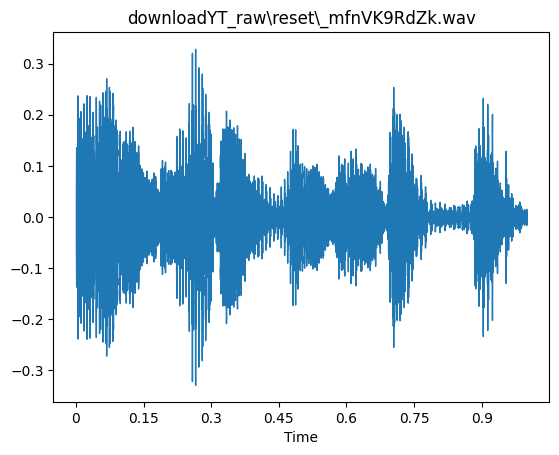

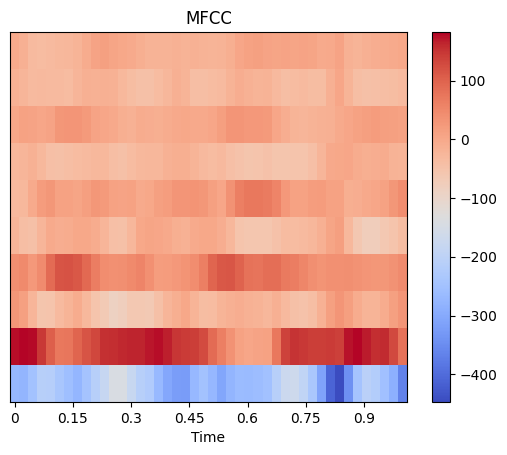

In [91]:
ma_cut = {}
ma_cut['r_shift'] = Right_Shift_Time # The unit is (s)

# Extract video ID from the video URL
if "youtu.be" in video_url:
    video_id = video_url.split("youtu.be/")[1]
elif "watch?v=" in video_url:    
    video_id = video_url.split("watch?v=")[1]
else:
    print("The link is error: {}".format(video_url))
    
audio_file = os.path.join('downloadYT_raw', search_pattern, (video_id + r'.wav'))

if audio_file:
    # Transcribe audio and grep desired paragraph
    f_log = None
    dict_single_log = transcribe_cut_audio(f_log, audio_file, search_pattern, video_id, {}, ma_cut)
    # print("Done {}!".format(dl_count))
    
    # Draw the new update wav
    out_audio_file = os.path.join('keyword', search_pattern, (video_id +r'_nohash_0' +r'.wav'))
    y, sr = librosa.load(out_audio_file)
    plt.figure()
    librosa.display.waveshow(y, sr=sr)
    plt.title(audio_file)
    plt.show()
    
    # 計算梅爾頻率倒譜係數
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10)
    
    # 繪製梅爾頻率倒譜係數圖
    fig, ax = plt.subplots()
    img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
    fig.colorbar(img, ax=ax)
    ax.set(title='MFCC')
    plt.show()
    
else:
    print("Error downloading audio.")

#Update log
#with open('cut_log.json', 'r') as openfile:
#    # Reading from json file
#    cut_log_json = json.load(openfile)
    
with open("keyword/{}_cut_log.json".format(search_pattern), "w") as outfile:
    cut_log_json = {}
    cut_log_json[video_id] = Right_Shift_Time
    #cut_log_json[video_id]['r_shift'] = Right_Shift_Time
    json.dump(cut_log_json, outfile)        

## 5.

In [106]:
ID = "_mfnVK9RdZk_nohash_0".split('_nohash')[0]
no_hash_number = 1
video_url = "https://youtu.be/" + ID
l_boundary = 0.45
r_boundary = 0.8

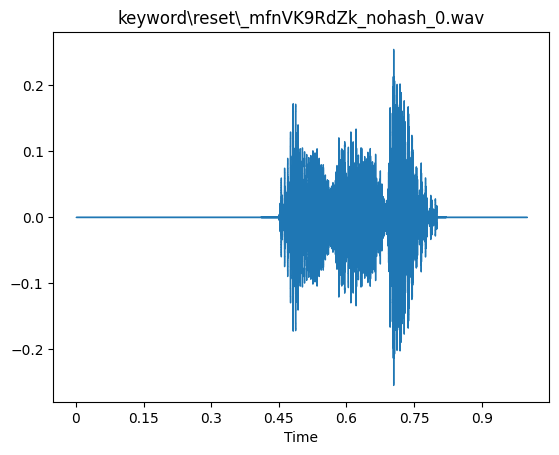

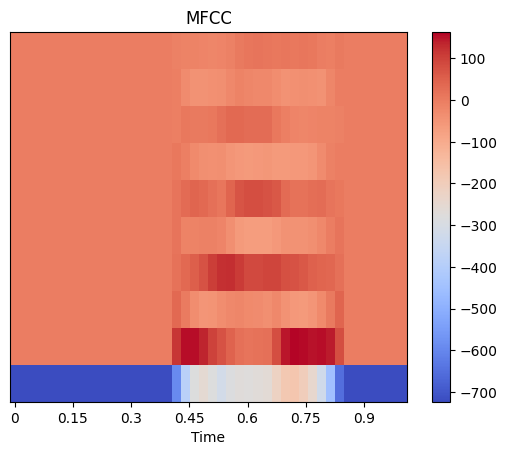

In [107]:

# Extract video ID from the video URL
if "youtu.be" in video_url:
    video_id = video_url.split("youtu.be/")[1]
elif "watch?v=" in video_url:    
    video_id = video_url.split("watch?v=")[1]
else:
    print("The link is error: {}".format(video_url))

input_file = video_id + '_nohash_0.wav'
output_file = video_id + '_nohash_{}.wav'.format(no_hash_number)
audio_file = os.path.join('keyword', search_pattern, input_file)

if audio_file:
    # Transcribe audio and grep desired paragraph
    f_log = None
    #dict_single_log = transcribe_cut_audio(f_log, audio_file, search_pattern, video_id, {}, {})
    # print("Done {}!".format(dl_count))
    
    # The PCM array's idx           
    rate, data = read(audio_file)
    
    np.random.seed(42)
    #if (l_boundary < r_boundary) and l_boundary >= 0 and r_boundary <= 1:
    #    for idx in range(0, (int)(np.floor(l_boundary*rate))):
    #        data[idx] = np.random.randint(-250, 250)
    #    for idx in range((int)(np.floor(r_boundary*rate)), 16000):
    #        data[idx] = np.random.randint(-250, 250)
            
    if (l_boundary < r_boundary) and l_boundary >= 0 and r_boundary <= 1:
        for idx in range(0, (int)(np.floor(l_boundary*rate))):
            data[idx] = 0
        for idx in range((int)(np.floor(r_boundary*rate)), 16000):
            data[idx] = 0           
    
    write(os.path.join('keyword', search_pattern, output_file), rate, data)
    
    # Draw the new update wav
    out_audio_file = os.path.join('keyword', search_pattern, output_file)
    y, sr = librosa.load(out_audio_file)
    plt.figure()
    librosa.display.waveshow(y, sr=sr)
    plt.title(audio_file)
    plt.show()
    
    # 計算梅爾頻率倒譜係數
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10)
    
    # 繪製梅爾頻率倒譜係數圖
    fig, ax = plt.subplots()
    img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
    fig.colorbar(img, ax=ax)
    ax.set(title='MFCC')
    plt.show()
    
else:
    print("Error downloading audio.")

#Update log
#with open('cut_log.json', 'r') as openfile:
#    # Reading from json file
#    cut_log_json = json.load(openfile)
    
with open("keyword/{}_cut_log.json".format(search_pattern), "w") as outfile:
    cut_log_json = {}
    cut_log_json[video_id] = Right_Shift_Time
    #cut_log_json[video_id]['r_shift'] = Right_Shift_Time
    json.dump(cut_log_json, outfile)        

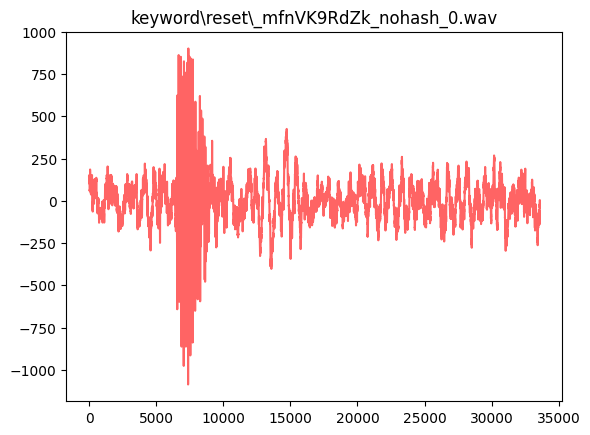

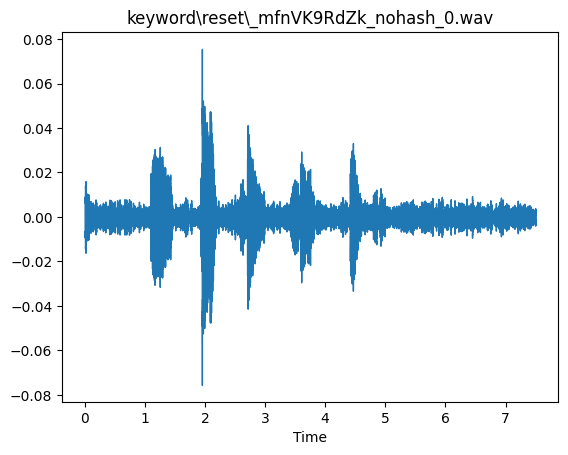

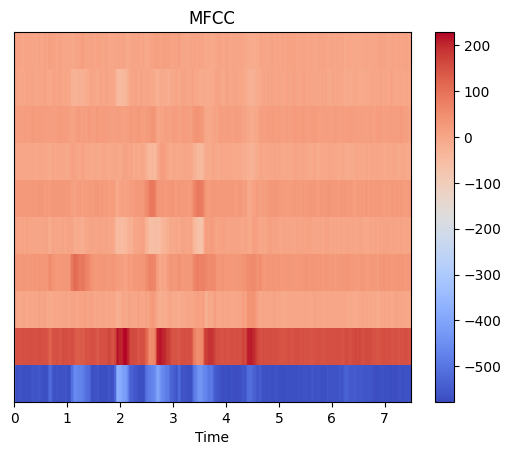

In [98]:
# Draw the new update wav
out_audio_file = '1694165048_nohash.wav'


# The PCM array's idx           
rate, data = read(out_audio_file)

#for idx in range((int)(np.floor(6*rate)), (int)(np.floor(6.1*rate))):
    #print(data[idx])

plt.figure()
plt.plot(data[(int)(np.floor(4*rate)): (int)(np.floor(6.1*rate))],color=(255/255,100/255,100/255))
plt.title(audio_file)
plt.show()


y, sr = librosa.load(out_audio_file)
plt.figure()
librosa.display.waveshow(y, sr=sr)
plt.title(audio_file)
plt.show()

# 計算梅爾頻率倒譜係數
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10)

# 繪製梅爾頻率倒譜係數圖
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')
plt.show()